# XXX Preprocess
xx/xx/202x

MAJOR UPDATES: 05/09/2024

In [1]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import os 
import joblib
import re
import datetime
import scipy


import warnings
warnings.filterwarnings('ignore')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append('/sc/arion/projects/guLab/Alie/SWB/ephys_analysis/LFPAnalysis/')

In [4]:
from LFPAnalysis import lfp_preprocess_utils, sync_utils, analysis_utils, nlx_utils

In [5]:
# Specify root directory for un-archived data and results 
base_dir = '/sc/arion/projects/guLab/Alie/SWB/'
anat_dir = f'{base_dir}ephys_analysis/recon_labels/'
neural_dir = f'{base_dir}ephys_analysis/data/'
behav_dir = f'{base_dir}swb_behav_models/data/behavior_preprocessed/'

subj_id = 'MS001'
subj_format = ['edf']
subj_site = ['MSSM']


# Make mne_data


### Load and resample data


In [6]:
edf_files = glob(f'{neural_dir}{subj_id}/raw/*.edf')

mne_data = mne.io.read_raw_edf(edf_files[0], preload=True)


Extracting EDF parameters from /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS001/raw/MS001_SWB.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1119999  =      0.000 ...  2187.498 secs...


In [7]:
mne_data

<RawEDF | MS001_SWB.edf, 276 x 1120000 (2187.5 s), ~2.30 GB, data loaded>

In [8]:
# mne_data.ch_names

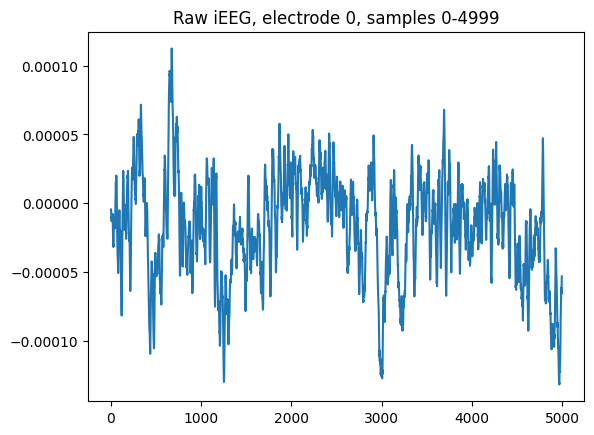

In [9]:
# Sanity check one channel data

plt.plot(mne_data._data[0,:4999])
plt.title("Raw iEEG, electrode 0, samples 0-4999")
plt.show()

### Photodiode
- examine photodiode 

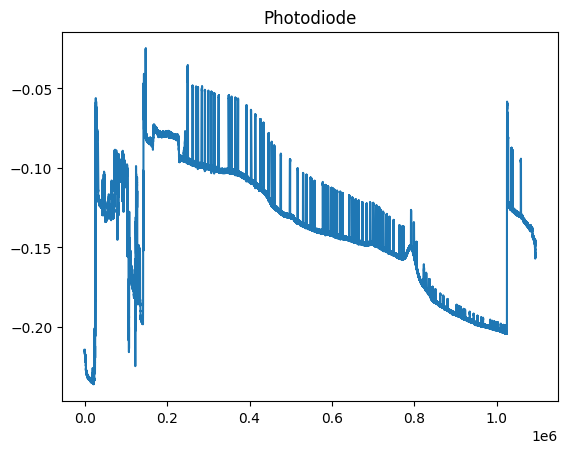

In [11]:
# Sanity check the photodiode
trig_ix = mne_data.ch_names.index("DC1")
plt.plot(mne_data._data[trig_ix])
plt.title("Photodiode")
plt.show()

In [12]:
mne_data.save(f'{neural_dir}{subj_id}/photodiode.fif', picks='DC1', overwrite=True)

Overwriting existing file.
Writing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS001/photodiode.fif
Closing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS001/photodiode.fif
[done]


In [13]:
mne_data.drop_channels(['DC1'])

<RawEDF | MS001_SWB.edf, 275 x 1093750 (2187.5 s), ~2.24 GB, data loaded>

### Resampling data 

In [10]:
#resampling if patient is not sampled at 512
resample_sr = 500
mne_data.resample(sfreq=resample_sr, npad='auto', n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
ERROR: ld.so: object '/hpc/packages/minerva-centos7/xalt/3.0.1/lib64/libxalt_init.so' from LD_PRELOAD cannot be preloaded: ignored.
ERROR: ld.so: object '/hpc/packages/minerva-centos7/xalt/3.0.1/lib64/libxalt_init.so' from LD_PRELOAD cannot be preloaded: ignored.
ERROR: ld.so: object '/hpc/packages/minerva-centos7/xalt/3.0.1/lib64/libxalt_init.so' from LD_PRELOAD cannot be preloaded: ignored.
ERROR: ld.so: object '/hpc/packages/minerva-centos7/xalt/3.0.1/lib64/libxalt_init.so' from LD_PRELOAD cannot be preloaded: ignored.
ERROR: ld.so: object '/hpc/packages/minerva-centos7/xalt/3.0.1/lib64/libxalt_init.so' from LD_PRELOAD cannot be preloaded: ignored.
ERROR: ld.so: object '/hpc/packages/minerva-centos7/xalt/3.0.1/lib64/libxalt_init.so' from LD_PRELOAD cannot be preloaded: ignored.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:    5.6s
[Paralle

<RawEDF | MS001_SWB.edf, 276 x 1093750 (2187.5 s), ~2.25 GB, data loaded>

### Notch filter line noise

In [14]:
mne_data.info['line_freq'] = 60
# Notch out 60 Hz noise and harmonics 
mne_data.notch_filter(freqs=(60, 120, 180, 240))

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3301 samples (6.602 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 275 out of 275 | elapsed:    9.7s finished


<RawEDF | MS001_SWB.edf, 275 x 1093750 (2187.5 s), ~2.24 GB, data loaded>

### Anatomical Localization

In [15]:
### Rename channels to be lowercase before anatomical localization
new_name_dict = {x:x.replace(" ", "").lower() for x in mne_data.ch_names}
mne_data.rename_channels(new_name_dict)

<RawEDF | MS001_SWB.edf, 275 x 1093750 (2187.5 s), ~2.24 GB, data loaded>

In [16]:
# Load the electrode localization data
anat_file = glob(f'{anat_dir}{subj_id}_labels.csv')[0]
elec_locs = pd.read_csv(anat_file)
# Sometimes there's extra columns with no entries: 
elec_locs = elec_locs[elec_locs.columns.drop(list(elec_locs.filter(regex='Unnamed')))]

elec_locs

label BN246label          x          y          z      mni_x  \
0     LaCaS1    A32sg_L  -8.952587  42.765351   7.745169  -9.250443   
1    LaCaS10      A9l_L -11.351734  49.160169  52.917875 -10.705220   
2    LaCaS11    Unknown -11.351734  49.160169  57.714976 -10.790170   
3    LaCaS12    Unknown -11.351734  49.160169  62.112319 -10.779800   
4     LaCaS2    A32sg_L  -9.352445  43.564703  12.942029  -9.498693   
..       ...        ...        ...        ...        ...        ...   
123   RmTpT5    Unknown  40.229932 -32.373764 -14.241546  46.004548   
124   RmTpT6    A37dl_R  43.828653 -34.771821 -11.842996  49.802904   
125   RmTpT7    A37dl_R  47.027516 -36.770202  -9.444445  53.100242   
126   RmTpT8    A37dl_R  51.026095 -38.768583  -7.845411  57.411817   
127   RmTpT9    A37dl_R  55.824389 -41.166640  -4.247585  62.565613   

         mni_y      mni_z       gm                                 NMM  \
0    36.452287  -8.560293     Gray  Left ACgG anterior cingulate gyrus   
1    54.795877  41.886395     Gray     Left SFG superior frontal gyrus   
2    56.511473  47.589415  Unknown                             Unknown   
3    58.090865  52.761764  Unknown                             Unknown   
4    38.675785  -2.957526     Gray  Left ACgG anterior cingulate gyrus   
..         ...        ...      ...                                 ...   
123 -47.067322  -5.385297    White         Right Cerebral White Matter   
124 -48.754227  -1.989788     Gray         Right Cerebral White Matter   
125 -49.935602   1.405315    White     Right MTG middle temporal gyrus   
126 -51.317997   3.928683     Gray     Right MTG middle temporal gyrus   
127 -52.490429   8.826684     Gray     Right MTG middle temporal gyrus   

               Anat                 AnatMacro    BN246  \
0          Area s32       L Mid Orbital Gyrus     L CG   
1           Unknown  L Superior Frontal Gyrus    L SFG   
2           Unknown                   Unknown  Unknown   
3           Unknown                   Unknown  Unknown   
4           Unknown                     L ACC     L CG   
..              ...                       ...      ...   
123         Unknown   R Middle Temporal Gyrus  Unknown   
124         Unknown   R Middle Temporal Gyrus    R MTG   
125         Unknown   R Middle Temporal Gyrus    R MTG   
126         Unknown   R Middle Temporal Gyrus    R MTG   
127  Area PGa (IPL)   R Middle Temporal Gyrus    R MTG   

                                      YBA_1  \
0                    Left cingulate gyrus D   
1           Left superior frontal gyrus 2 C   
2                                   Unknown   
3                                   Unknown   
4                    Left cingulate gyrus E   
..                                      ...   
123                                 Unknown   
124                                 Unknown   
125  Right superior middle temporal gyrus E   
126  Right superior middle temporal gyrus F   
127  Right superior middle temporal gyrus F   

                         Manual Examination Notes  
0                                       NaN   NaN  
1                                       NaN   NaN  
2                                       OOB   NaN  
3                                       OOB   NaN  
4                                       NaN   NaN  
..                                      ...   ...  
123                                      WM   NaN  
124  Right inferior middle temporal gyrus E   NaN  
125                                      WM   NaN  
126                                     NaN   NaN  
127                                     NaN   NaN  

[128 rows x 16 columns]

In [17]:
list(elec_locs.label)

['LaCaS1',
 'LaCaS10',
 'LaCaS11',
 'LaCaS12',
 'LaCaS2',
 'LaCaS3',
 'LaCaS4',
 'LaCaS5',
 'LaCaS6',
 'LaCaS7',
 'LaCaS8',
 'LaCaS9',
 'LAgIT1',
 'LAgIT10',
 'LAgIT2',
 'LAgIT3',
 'LAgIT4',
 'LAgIT5',
 'LAgIT6',
 'LAgIT7',
 'LAgIT8',
 'LAgIT9',
 'LHplT1',
 'LHplT10',
 'LHplT11',
 'LHplT12',
 'LHplT2',
 'LHplT3',
 'LHplT4',
 'LHplT5',
 'LHplT6',
 'LHplT7',
 'LHplT8',
 'LHplT9',
 'LmCmS1',
 'LmCmS2',
 'LmCmS3',
 'LmCmS4',
 'LmCmS5',
 'LmCmS6',
 'LmCmS7',
 'LmCmS8',
 'LmOlF1',
 'LmOlF10',
 'LmOlF11',
 'LmOlF12',
 'LmOlF2',
 'LmOlF3',
 'LmOlF4',
 'LmOlF5',
 'LmOlF6',
 'LmOlF7',
 'LmOlF8',
 'LmOlF9',
 'LmTpT1',
 'LmTpT10',
 'LmTpT2',
 'LmTpT3',
 'LmTpT4',
 'LmTpT5',
 'LmTpT6',
 'LmTpT7',
 'LmTpT8',
 'LmTpT9',
 'RaCaS1',
 'RaCaS10',
 'RaCaS11',
 'RaCaS12',
 'RaCaS2',
 'RaCaS3',
 'RaCaS4',
 'RaCaS5',
 'RaCaS6',
 'RaCaS7',
 'RaCaS8',
 'RaCaS9',
 'RAgIT1',
 'RAgIT10',
 'RAgIT2',
 'RAgIT3',
 'RAgIT4',
 'RAgIT5',
 'RAgIT6',
 'RAgIT7',
 'RAgIT8',
 'RAgIT9',
 'RHplT1',
 'RHplT10',
 'RHplT2',
 'RHp

In [18]:
anat_names = list(elec_locs.label.str.lower())
sum([ch not in mne_data.ch_names for ch in anat_names]) #if there are no missing channels, sum = 0. if sum >0, find the missing elecs
print([ch for ch in mne_data.ch_names if ch not in anat_names ]) #print extra channels in mne_data.ch_names and make sure none of them are neural channels (will be EEG etc.)

['lmoif1', 'lmoif2', 'lmoif3', 'lmoif4', 'lmoif5', 'lmoif6', 'lmoif7', 'lmoif8', 'lmoif9', 'lmoif10', 'lmoif11', 'lmoif12', 'rmoif1', 'rmoif2', 'rmoif3', 'rmoif4', 'rmoif5', 'rmoif6', 'rmoif7', 'rmoif8', 'rmoif9', 'rmoif10', 'rmoif11', 'rmoif12', 'laglt1', 'laglt2', 'laglt3', 'laglt4', 'laglt5', 'laglt6', 'laglt7', 'laglt8', 'laglt9', 'laglt10', 'c59', 'c60', 'c61', 'c62', 'c63', 'c64', 'raglt1', 'raglt2', 'raglt3', 'raglt4', 'raglt5', 'raglt6', 'raglt7', 'raglt8', 'raglt9', 'raglt10', 'lptpt1', 'lptpt2', 'lptpt3', 'lptpt4', 'lptpt5', 'lptpt6', 'lptpt7', 'lptpt8', 'lptpt9', 'lptpt10', 'c125', 'c126', 'c127', 'c128', 'rptpt1', 'rptpt2', 'rptpt3', 'rptpt4', 'rptpt5', 'rptpt6', 'rptpt7', 'rptpt8', 'rptpt9', 'rptpt10', 'fp1', 'f7', 't3', 't5', 'o1', 'f3', 'c3', 'p3', 'fp2', 'f8', 't4', 't6', 'o2', 'f4', 'c4', 'p4', 'fz', 'cz', 'pz', 'ekg1', 'ekg2', 'c160', 'c161', 'c162', 'c163', 'c164', 'c165', 'c166', 'c167', 'c168', 'c169', 'c170', 'c171', 'c172', 'c173', 'c174', 'c175', 'c176', 'c177',

In [19]:
new_mne_names, unmatched_names, unmatched_seeg = lfp_preprocess_utils.match_elec_names(mne_data.ch_names, elec_locs.label)


Number of electrodes in the mne file is greater than the number of electrodes in the localization file


In [20]:
unmatched_seeg #make sure there are no unmatched names


[]

In [21]:
new_name_dict = {x:y for (x,y) in zip(mne_data.ch_names, new_mne_names)}


In [22]:
new_name_dict #make sure this passes the eye test 


{'lmoif1': 'lmolf1',
 'lmoif2': 'lmolf2',
 'lmoif3': 'lmolf3',
 'lmoif4': 'lmolf4',
 'lmoif5': 'lmolf5',
 'lmoif6': 'lmolf6',
 'lmoif7': 'lmolf7',
 'lmoif8': 'lmolf8',
 'lmoif9': 'lmolf9',
 'lmoif10': 'lmolf10',
 'lmoif11': 'lmolf11',
 'lmoif12': 'lmolf12',
 'rmoif1': 'rmolf1',
 'rmoif2': 'rmolf2',
 'rmoif3': 'rmolf3',
 'rmoif4': 'rmolf4',
 'rmoif5': 'rmolf5',
 'rmoif6': 'rmolf6',
 'rmoif7': 'rmolf7',
 'rmoif8': 'rmolf8',
 'rmoif9': 'rmolf9',
 'rmoif10': 'rmolf10',
 'rmoif11': 'rmolf11',
 'rmoif12': 'rmolf12',
 'lacas1': 'lacas1',
 'lacas2': 'lacas2',
 'lacas3': 'lacas3',
 'lacas4': 'lacas4',
 'lacas5': 'lacas5',
 'lacas6': 'lacas6',
 'lacas7': 'lacas7',
 'lacas8': 'lacas8',
 'lacas9': 'lacas9',
 'lacas10': 'lacas10',
 'lacas11': 'lacas11',
 'lacas12': 'lacas12',
 'racas1': 'racas1',
 'racas2': 'racas2',
 'racas3': 'racas3',
 'racas4': 'racas4',
 'racas5': 'racas5',
 'racas6': 'racas6',
 'racas7': 'racas7',
 'racas8': 'racas8',
 'racas9': 'racas9',
 'racas10': 'racas10',
 'racas11': 'r

In [23]:
# Rename the mne data according to the localization data

mne_data.rename_channels(new_name_dict)

<RawEDF | MS001_SWB.edf, 275 x 1093750 (2187.5 s), ~2.24 GB, data loaded>

In [24]:
right_seeg_names = [i for i in mne_data.ch_names if i.startswith('r')]
left_seeg_names = [i for i in mne_data.ch_names if i.startswith('l')]
print(f'We have a total of {len(left_seeg_names)} left sEEG and {len(right_seeg_names)} right sEEG electrodes')
print(f'We have a total of {len(left_seeg_names) + len(right_seeg_names)} sEEG electrodes')



We have a total of 64 left sEEG and 64 right sEEG electrodes
We have a total of 128 sEEG electrodes


In [25]:
sEEG_mapping_dict = {f'{x}':'seeg' for x in left_seeg_names+right_seeg_names}
mne_data.set_channel_types(sEEG_mapping_dict)


<RawEDF | MS001_SWB.edf, 275 x 1093750 (2187.5 s), ~2.24 GB, data loaded>

In [26]:
drop_chans = list(set(mne_data.ch_names)^set(left_seeg_names+right_seeg_names))
mne_data.drop_channels(drop_chans) #number of chans should = number of seegs 

<RawEDF | MS001_SWB.edf, 128 x 1093750 (2187.5 s), ~1.04 GB, data loaded>

In [27]:
# make montage (convert mm to m)

montage = mne.channels.make_dig_montage(ch_pos=dict(zip(elec_locs.label, 
                                                        elec_locs[['mni_x', 'mni_y', 'mni_z']].to_numpy(dtype=float)/1000)),
                                        coord_frame='mni_tal')

mne_data.set_montage(montage, match_case=False, on_missing='warn')

<RawEDF | MS001_SWB.edf, 128 x 1093750 (2187.5 s), ~1.04 GB, data loaded>

## Signal Cleaning 
Methods:
- Use manual bad channel detection for **bipolar** referencing
    - bipolar referencing completely ignores channels labeled as 'bad' so do not remove unless absolutely necessary
    - remove ch if there is massive artifact in a channel not in the rest of probe 
    - if entire probe shows same artifact try to keep
- Remove additional channels as needed
- This process is iterative depending on how TFRs look. 

In [28]:
#this is just for my own personal info and to select how many channels to visualize at a time
ch_names = list(elec_locs.label.str.lower())
pattern = '[0-9]'
ch_names_no_num = [re.sub(pattern, '', i) for i in ch_names]
probe_names = np.unique(ch_names_no_num)
# probe_names

In [30]:
probe_ch_counts = {} #need this to select channel number for visualization
for p in probe_names:
    c = ch_names_no_num.count(p)
    probe_ch_counts[p] = c

In [3107]:
probe_ch_counts

{'lacas': 12,
 'lagit': 10,
 'lhplt': 12,
 'lmcms': 8,
 'lmolf': 12,
 'lmtpt': 10,
 'racas': 12,
 'ragit': 10,
 'rhplt': 10,
 'rmcms': 10,
 'rmolf': 12,
 'rmtpt': 10}

### Compare auto detection result to actual lfp data - if trusted save auto result as mne bads
- often inaccurate - verify that all included channels make sense and all channels that should be included are
- take out any crazy noise, especially if it's only in one channel on probe (won't be cancelled out)

In [39]:
# mne_data.info['bads'] = lfp_preprocess_utils.detect_bad_elecs(mne_data, sEEG_mapping_dict) #this is likely inaccurate - just use to get an idea 
lfp_preprocess_utils.detect_bad_elecs(mne_data, sEEG_mapping_dict)

['lagit7',
 'lagit8',
 'lmtpt4',
 'racas3',
 'rmcms10',
 'rmcms9',
 'rmtpt10',
 'rmtpt2',
 'rmtpt3',
 'rmtpt4',
 'rmtpt5',
 'rmtpt6',
 'rmtpt8',
 'rmtpt9']

<IPython.core.display.Javascript object>


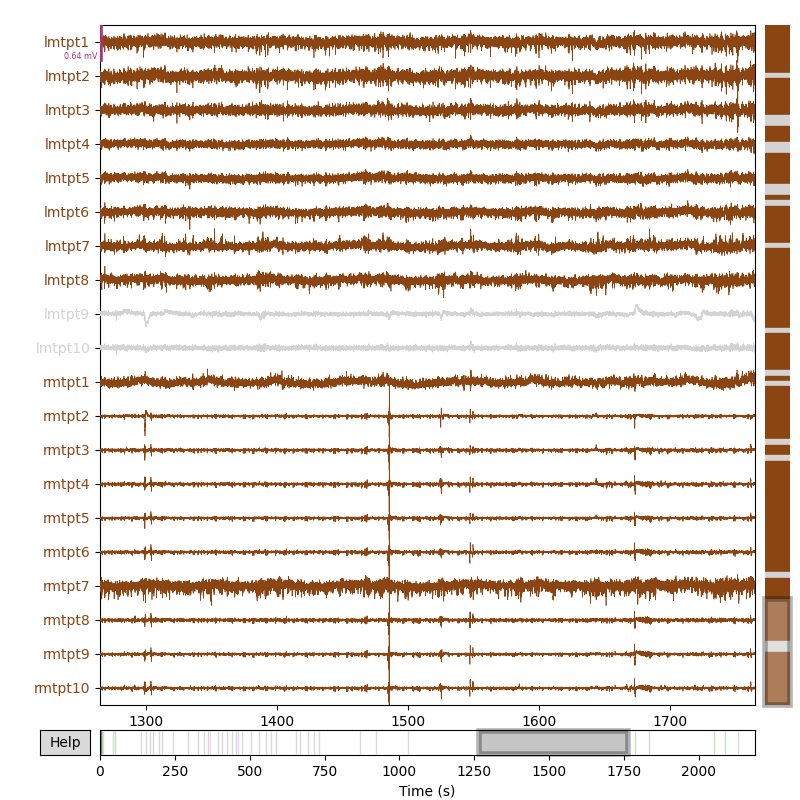

<IPython.core.display.Javascript object>


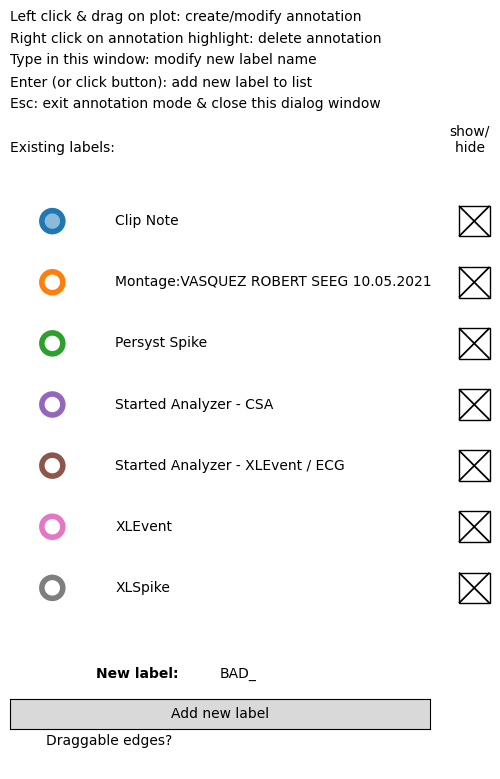

In [39]:
 %matplotlib notebook
fig = mne_data.plot(start=0, duration=1000, n_channels=40, scalings=mne_data._data.max()/50)


In [33]:
mne_data.info['bads']

['lmolf10',
 'rmolf6',
 'rmolf7',
 'rmolf11',
 'rmolf12',
 'lacas8',
 'lacas10',
 'lacas7',
 'racas6',
 'lagit10',
 'ragit8',
 'ragit10',
 'lhplt11',
 'rhplt2',
 'lmtpt10',
 'lmtpt9',
 'rmcms6']

In [3109]:
mne_data.info #sanity check that bads info saved

<Info | 10 non-empty values
 bads: 17 items (lmolf10, rmolf6, rmolf7, rmolf11, rmolf12, lacas8, ...)
 ch_names: lmolf1, lmolf2, lmolf3, lmolf4, lmolf5, lmolf6, lmolf7, lmolf8, ...
 chs: 128 sEEG
 custom_ref_applied: False
 dig: 128 items (128 EEG)
 highpass: 0.0 Hz
 line_freq: 60.0
 lowpass: 250.0 Hz
 meas_date: 2001-01-01 09:58:54 UTC
 nchan: 128
 projs: []
 sfreq: 500.0 Hz
>

# Bipolar Re-referencing 
- plot lfp bp data
- plot psd bp data
- save bp reref data 


In [34]:
#run if only re-ref
anat_file = glob(f'{anat_dir}/{subj_id}_labels.csv')[0]
# mne_data = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/raw_ieeg.fif', preload=True)

### Bipolar Re-ref

In [35]:
# Re-reference neural data
mne_data_bp_reref = lfp_preprocess_utils.ref_mne(mne_data=mne_data, 
                                              elec_path=anat_file, 
                                              method='bipolar', 
                                              site='MSSM')

sEEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=28, n_times=1093750
    Range : 0 ... 1093749 =      0.000 ...  2187.498 secs
Ready.
Added the following bipolar channels:
lacas1-lacas2, lacas2-lacas3, lacas5-lacas6, lagit1-lagit2, lagit2-lagit3, lagit3-lagit4, lagit8-lagit9, lhplt1-lhplt2, lhplt2-lhplt3, lhplt3-lhplt4, lhplt7-lhplt8, lhplt8-lhplt9, lhplt9-lhplt10, lmcms1-lmcms2, lmcms2-lmcms3, lmolf8-lmolf9, lmtpt1-lmtpt2, lmtpt7-lmtpt8, racas4-racas5, racas9-racas10, ragit1-ragit2, ragit2-ragit3, rhplt1-rhplt3, rmcms1-rmcms2, rmcms2-rmcms3, rmcms3-rmcms4, rmtpt1-rmtpt2, rmtpt8-rmtpt9


In [36]:
mne_data_bp_reref

<RawEDF | MS001_SWB.edf, 28 x 1093750 (2187.5 s), ~233.7 MB, data loaded>

In [3114]:
mne_data_bp_reref.ch_names

['lacas1-lacas2',
 'lacas2-lacas3',
 'lacas5-lacas6',
 'lagit1-lagit2',
 'lagit2-lagit3',
 'lagit3-lagit4',
 'lagit8-lagit9',
 'lhplt1-lhplt2',
 'lhplt2-lhplt3',
 'lhplt3-lhplt4',
 'lhplt7-lhplt8',
 'lhplt8-lhplt9',
 'lhplt9-lhplt10',
 'lmcms1-lmcms2',
 'lmcms2-lmcms3',
 'lmolf8-lmolf9',
 'lmtpt1-lmtpt2',
 'lmtpt7-lmtpt8',
 'racas4-racas5',
 'racas9-racas10',
 'ragit1-ragit2',
 'ragit2-ragit3',
 'rhplt1-rhplt3',
 'rmcms1-rmcms2',
 'rmcms2-rmcms3',
 'rmcms3-rmcms4',
 'rmtpt1-rmtpt2',
 'rmtpt8-rmtpt9']

#### Examine bp ref data 
- examine lfp plot to see if major artifacts are still present
- examine psd to see if there are any major peaks in channels

<IPython.core.display.Javascript object>


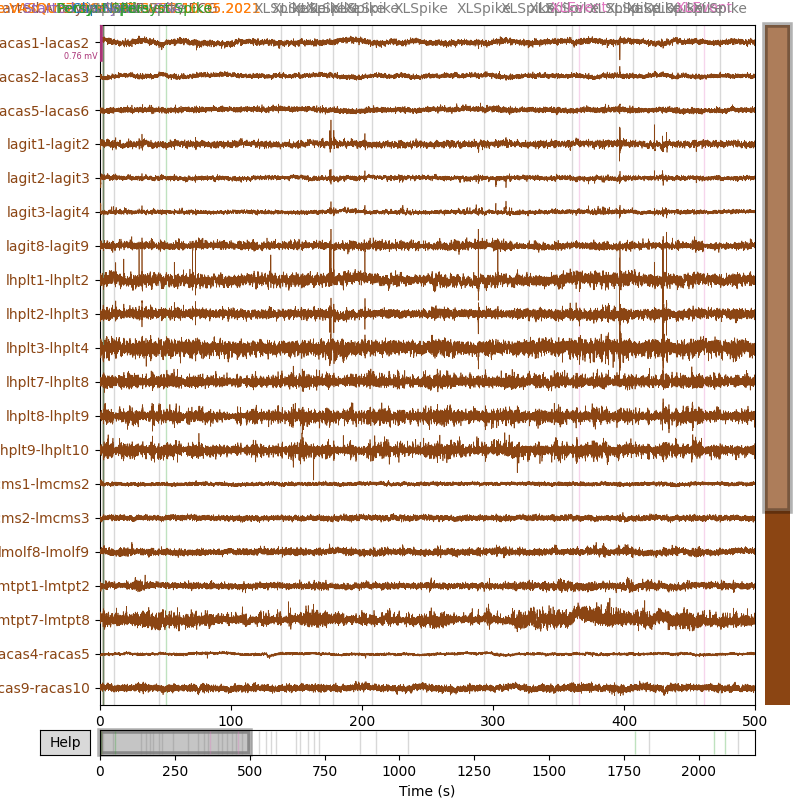

<IPython.core.display.Javascript object>


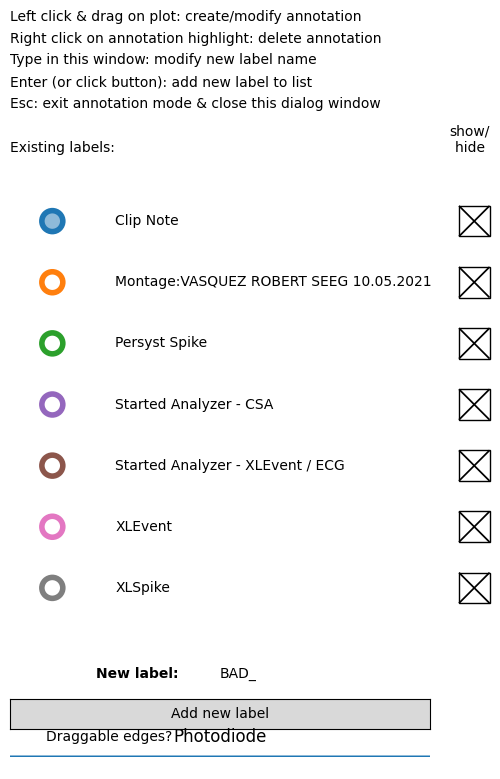

In [3113]:
 %matplotlib notebook
fig = mne_data_bp_reref.plot(start=0, duration=1000, n_channels=40, scalings=mne_data_bp_reref._data.max())


In [ ]:
mne_data_bp_reref.compute_psd().plot()

In [37]:
mne_data_bp_reref.save(f'{neural_dir}{subj_id}/bp_ref_ieeg.fif',overwrite=True)

Overwriting existing file.
Writing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS001/bp_ref_ieeg.fif
Closing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS001/bp_ref_ieeg.fif
[done]


## Save mne_data

In [38]:
mne_data.save(f'{neural_dir}{subj_id}/raw_ieeg.fif',overwrite=True)

Overwriting existing file.
Writing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS001/raw_ieeg.fif
Closing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS001/raw_ieeg.fif
[done]


# Epoching + TFRs
- Check whether data is ready to be analyzed - if this step shows noise then steps above should be repeated
- Align photodiode to behavior 
- Epoch data (and mark bad epochs)
- Baseline data
- Visualize TFRs 

In [39]:
#remove mne_data from environment to save memory 
del mne_data, mne_data_bp_reref

### Photodiode Alignment

In [40]:
#load behavior data
behav_df = pd.read_csv(f'{behav_dir}{subj_id}_pt_task_data')
behav_df = behav_df[behav_df.columns.drop(list(behav_df.filter(regex='Unnamed')))]
# behav_df = behav_df[behav_df['FeedbackOnset'] != 0] #remove fail trials from behav df
beh_ts = behav_df['TrialOnset'] #timestamp that should be aligned to photodiode 
#load photodiode data
photodiode_data = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/photodiode.fif', preload=True)

Opening raw data file /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS001/photodiode.fif...
Isotrak not found
    Range : 0 ... 1093749 =      0.000 ...  2187.498 secs
Ready.
Reading 0 ... 1093749  =      0.000 ...  2187.498 secs...


In [ ]:
#resampling if patient is not sampled at 512
resample_sr = 500
photodiode_data.resample(sfreq=resample_sr, npad='auto', n_jobs=-1)

In [41]:
photodiode_data

<Raw | photodiode.fif, 1 x 1093750 (2187.5 s), ~8.4 MB, data loaded>

In [901]:
### Photodiode alignment
smoothSize=11
windSize=15
height=0.7

# Synchronize to the photodiode or whatever your neural sync signal is
slope, offset = sync_utils.synchronize_data(beh_ts, 
                                            photodiode_data, #
                                            smoothSize, windSize, height)

8 blocks
........

found matches for 30 of 42 pulses
4 blocks
....

found matches for 10 of 42 pulses


In [902]:
print(slope, offset,smoothSize,windSize,height)

1.4759808236189775 -4126.432524797699 25 5 1.25


In [877]:
[(x*slope + offset) for x in beh_ts]

[-4109.439693266617,
 -4083.216522717539,
 -3984.7438383086487,
 -3931.9866981793493,
 -3884.430500915772,
 -3848.365072092385,
 -3821.3731510976104,
 -3745.914450645436,
 -3718.5118905500285,
 -3683.1565473018845,
 -3641.54695015078,
 -3608.3553127478376,
 -3585.429848746977,
 -3496.1945845021037,
 -3469.1867632921344,
 -3441.5873271564174,
 -3381.629309328363,
 -3349.8539152732205,
 -3318.7881978161795,
 -3263.217841089623,
 -3233.532453921103,
 -3205.438925228149,
 -3158.8497300786134,
 -3124.684498508831,
 -3098.120488525443,
 -3027.131345372264,
 -3000.572047228263,
 -2972.0238558966585,
 -2927.3502450282613,
 -2898.272937802045,
 -2871.1175345860456,
 -2832.7255073213246,
 -2799.950354885159,
 -2770.804327947877,
 -2722.9119509841175,
 -2694.84063486205,
 -2666.253468058212,
 -2618.177287330055,
 -2586.403205737607,
 -2553.0256130162516,
 -2508.6087481156583,
 -2474.679453589696,
 -2450.357528298142,
 -2403.7494535939395,
 -2374.041489609269,
 -2349.6886862979063,
 -2303.88595148

In [ ]:
#### verify photodiode alignment
    # requires newer functions from new sync utils package (older version used here)

def get_neural_ts_photodiode(mne_sync, smoothSize=11, height=0.5):
    """
    get neural ts from photodiode
    """

    sig = np.squeeze(moving_average(mne_sync._data, n=smoothSize))
    timestamp = np.squeeze(np.arange(len(sig))/mne_sync.info['sfreq'])
    sig = scipy.stats.zscore(sig)

    trig_ix = np.where((sig[:-1]<=height)*(sig[1:]>height))[0] # rising edge of trigger
    
    neural_ts = timestamp[trig_ix]
    neural_ts = np.array(neural_ts)

    return neural_ts


def moving_average(a, n=11) :
    """
    Computes the moving average of a given array a with a window size of n.

    Parameters
    ----------
    a : np.ndarray
        The input array to compute the moving average on.
    n : int, optional
        The window size of the moving average. Default is 11.

    Returns
    -------
    np.ndarray
        The moving average of the input array a.
    """
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n


pulses = [(x*slope + offset) for x in beh_ts]
# moving_average
neural_ts = get_neural_ts_photodiode(photodiode_data, smoothSize=15, height=0.7)
neural_ts.shape


plt.plot(neural_ts,'o')
# plt.plot(pulses,'o')
plt.show()

plt.plot(scipy.stats.zscore(photodiode_data._data[0,:]))
# plt.plot(pulses)
plt.plot(np.array(pulses)*1024, 
         np.ones_like(np.array(pulses)*1024)-0.5, '.')
# plt.plot(neural_ts*1024, 
#          np.ones_like(neural_ts)-0.25, '.')
plt.xlim([1900000,2200000])
plt.show()

temp_diode = photodiode_data.copy()
temp_diode._data[0,0:1000000] = np.min(temp_diode._data[0,:])
temp_diode._data[0,3000000:] = np.min(temp_diode._data[0,:])

In [ ]:
# Sanity check the photodiode
# plt.plot(photodiode_data._data[0,:])
# plt.plot(zscore(photodiode_data._data[0,:]))
# plt.title("Photodiode")
# plt.show()

In [ ]:
pulses = [(x*slope + offset) for x in beh_ts]

In [ ]:
# moving_average
neural_ts = get_neural_ts_photodiode(temp_diode, smoothSize=15, height=0.75)
neural_ts.shape

In [ ]:
plt.plot(neural_ts,'o')
# plt.plot(pulses,'o')

In [ ]:
# plt.plot(neural_ts,'o')
# plt.plot(pulses,'o')

In [ ]:
plt.plot(scipy.stats.zscore(photodiode_data._data[0,:]))
# plt.plot(pulses)
plt.plot(np.array(pulses)*1024, 
         np.ones_like(np.array(pulses)*1024)-0.5, '.')
# plt.plot(neural_ts*1024, 
#          np.ones_like(neural_ts)-0.25, '.')
plt.xlim([1600000,2200000])

In [837]:
# del epochs_all_baseline, power_epochs, plot_data

## Epoch Data
- Epoch neural data into trial epochs 
- Add behavioral data to epochs metadata
- Save epochs
- Baseline + decompose data into TFRs
- Plot + save TFRs (examine quality)

### Epoch data

In [73]:
# IED removal requires that we set some parameters for IED detection. 
# 1. peak_thresh: how many stds should they exceed the baseline by? 
# 2. closeness_thresh: how close should they be allowed to be (in sec) to other candidate IEDs? 
# 3. width_thresh: how wide should they have to be (in sec)?

# Defaults:
IED_args = {'peak_thresh':4,
           'closeness_thresh':0.25, 
           'width_thresh':0.2}

In [74]:
# Create a dictionary with your event name (matching your dataframe), and the time-window for the event
evs = {'TrialOnset': [-1.0, 0], #ITI is always at least one second + 10ms buffer for wavelet padding (no horizontal smearing)
       'DecisionOnset': [0, 5.0]} #1 sec decision period + 2 second outcome + 3 second counterfactual

In [75]:
epochs_all_evs = {f'{x}': np.nan for x in evs}

In [ ]:
# quality control before epoching

# double check slope/offset
print(slope,offset)

# changed function to input beh_ts vector used for synching, not behav_df[event].values
# added downsamp_factor=None,

In [ ]:
for event in evs.keys():
    # Make the epochs. 
    ev_epochs = lfp_preprocess_utils.make_epochs(load_path=f'{neural_dir}{subj_id}/bp_ref_ieeg.fif', 
                 slope=slope, offset=offset,
                 behav_name=event, behav_times=behav_df[event].values,downsamp_factor=None,
#                  behav_name=event, behav_times=beh_ts,downsamp_factor=None,
                 ev_start_s=evs[event][0], ev_end_s=evs[event][1], buf_s = 1, IED_args=IED_args) #1.0 buf unsaved

    epochs_all_evs[event] = ev_epochs
    

Opening raw data file /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS001/bp_ref_ieeg.fif...
    Range : 0 ... 1093749 =      0.000 ...  2187.498 secs
Ready.
Reading 0 ... 1093749  =      0.000 ...  2187.498 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00 Hz)
- Filter length: 265 samples (0.530 sec)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 out of  28 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 out of  28 | elapsed:    1.2s finished


In [93]:
epochs_all_evs 


{'TrialOnset': <Epochs |  146 events (all good), -2 - 1 sec, baseline off, ~46.9 MB, data loaded, with metadata,
  'TrialOnset': 146>,
 'DecisionOnset': <Epochs |  146 events (all good), -1 - 6 sec, baseline off, ~109.3 MB, data loaded, with metadata,
  'DecisionOnset': 146>}

### Add behavioral data to metadata 

In [94]:
behav_df.columns

Index(['Round', 'Trial Num', 'TrialType', 'TrialOnset', 'ChoiceOnset',
       'DecisionOnset', 'FeedbackOnset', 'RT', 'SafeBet', 'LowBet', 'HighBet',
       'HighBetPos', 'GamblePos', 'ChoicePos', 'GambleChoice', 'Outcome',
       'Profit', 'TotalProfit', 'GambleEV', 'CR', 'choiceEV', 'RPE',
       'totalCPE', 'decisionCPE', 'totalRegret', 'decisionRegret',
       'totalRelief', 'decisionRelief', 'totalCF', 'decisionCF', 'pRPE',
       'nRPE', 'util_safe_mle', 'util_gamble_mle', 'wSafe_mle', 'wHigh_mle',
       'wLow_mle', 'p_safe_mle', 'p_gamble_mle', 'util_safe_emmap',
       'util_gamble_emmap', 'wSafe_emmap', 'wHigh_emmap', 'wLow_emmap',
       'p_safe_emmap', 'p_gamble_emmap', 'util_tCPE_mle', 'util_dCPE_mle',
       'util_tCF_mle', 'util_dCF_mle', 'util_tRegret_mle', 'util_dRegret_mle',
       'util_tRelief_mle', 'util_dRelief_mle', 'util_RPE_mle', 'util_pRPE_mle',
       'util_nRPE_mle', 'util_tCPE_emmap', 'util_dCPE_emmap', 'util_tCF_emmap',
       'util_dCF_emmap', 'util_tRegr

In [95]:
behav_params = ['TrialType','SafeBet', 'LowBet', 'HighBet','GambleChoice', 'Outcome',
       'Profit', 'TotalProfit', 'GambleEV', 'CR', 'choiceEV', 'RPE',
       'totalCPE', 'decisionCPE', 'totalRegret', 'decisionRegret',
       'totalRelief', 'decisionRelief', 'totalCF', 'decisionCF', 'pRPE',
       'nRPE']

# behav_params = ['TrialType','SafeBet', 'LowBet', 'HighBet','GambleChoice', 'Outcome',
#        'Profit', 'TotalProfit', 'GambleEV', 'CR', 'choiceEV', 'RPE',
#        'totalCPE', 'decisionCPE', 'totalRegret', 'decisionRegret',
#        'totalRelief', 'decisionRelief', 'totalCF', 'decisionCF', 'pRPE',
#        'nRPE', 'util_safe_mle', 'util_gamble_mle', 'wSafe_mle', 'wHigh_mle',
#        'wLow_mle', 'p_safe_mle', 'p_gamble_mle', 'util_safe_emmap',
#        'util_gamble_emmap', 'wSafe_emmap', 'wHigh_emmap', 'wLow_emmap',
#        'p_safe_emmap', 'p_gamble_emmap', 'util_tCPE_mle', 'util_dCPE_mle',
#        'util_tCF_mle', 'util_dCF_mle', 'util_tRegret_mle', 'util_dRegret_mle',
#        'util_tRelief_mle', 'util_dRelief_mle', 'util_RPE_mle', 'util_pRPE_mle',
#        'util_nRPE_mle', 'util_tCPE_emmap', 'util_dCPE_emmap', 'util_tCF_emmap',
#        'util_dCF_emmap', 'util_tRegret_emmap', 'util_dRegret_emmap',
#        'util_tRelief_emmap', 'util_dRelief_emmap', 'util_RPE_emmap',
#        'util_pRPE_emmap', 'util_nRPE_emmap']

In [96]:
for event in evs.keys():

    event_metadata = epochs_all_evs[event].metadata.copy()
    
    #independent vars
    for param in behav_params: 
        event_metadata[param] = behav_df[param].tolist()

    epochs_all_evs[event].metadata = event_metadata 
    

Replacing existing metadata with 86 columns
Replacing existing metadata with 86 columns


In [97]:
epochs_all_evs[event].metadata

lacas1-lacas2 lacas2-lacas3 lacas5-lacas6 lagit1-lagit2 lagit2-lagit3  \
0             NaN           NaN           NaN           NaN           NaN   
1             NaN           NaN           NaN         noise           NaN   
2             NaN           NaN           NaN           NaN           NaN   
3             NaN           NaN           NaN         noise           NaN   
4             NaN           NaN           NaN           NaN           NaN   
..            ...           ...           ...           ...           ...   
141           NaN           NaN           NaN         noise           NaN   
142           NaN           NaN           NaN           NaN           NaN   
143           NaN           NaN           NaN         noise           NaN   
144           NaN           NaN           NaN         noise           NaN   
145           NaN           NaN           NaN         noise           NaN   

    lagit3-lagit4 lagit8-lagit9 lhplt1-lhplt2 lhplt2-lhplt3 lhplt3-lhplt4  \
0           noise           NaN           NaN           NaN           NaN   
1           noise           NaN           NaN           NaN           NaN   
2             NaN           NaN           NaN           NaN           NaN   
3             NaN           NaN           NaN           NaN           NaN   
4             NaN           NaN           NaN           NaN           NaN   
..            ...           ...           ...           ...           ...   
141           NaN           NaN           NaN           NaN           NaN   
142           NaN           NaN           NaN           NaN           NaN   
143           NaN           NaN         noise           NaN           NaN   
144           NaN           NaN         noise           NaN           NaN   
145           NaN           NaN         noise           NaN           NaN   

     ... util_dCPE_emmap util_tCF_emmap util_dCF_emmap util_tRegret_emmap  \
0    ...       -0.390483       0.397661       0.390483          -0.397661   
1    ...       -0.034030       0.479485       0.000000          -0.513515   
2    ...        0.259532       0.000000       0.591999           0.000000   
3    ...       -0.018420       0.000000      -0.042015          -0.060435   
4    ...       -0.032019       0.000000      -0.050661          -0.082680   
..   ...             ...            ...            ...                ...   
141  ...        0.191717       0.000000       0.000000           0.000000   
142  ...       -0.042240       0.042240       0.042240          -0.042240   
143  ...        0.007434       0.000000      -0.050661          -0.043227   
144  ...       -0.007193       0.000000      -0.016406          -0.023599   
145  ...        0.132541       0.000000       0.490974           0.000000   

    util_dRegret_emmap util_tRelief_emmap util_dRelief_emmap util_RPE_emmap  \
0            -0.390483           0.000000           0.000000      -0.397661   
1            -0.034030           0.000000           0.000000      -0.479485   
2             0.000000           0.851531           0.259532       0.000000   
3            -0.018420           0.000000           0.000000       0.000000   
4            -0.032019           0.000000           0.000000       0.000000   
..                 ...                ...                ...            ...   
141           0.000000           0.191717           0.191717       0.000000   
142          -0.042240           0.000000           0.000000       0.000000   
143           0.007434           0.000000           0.000000       0.000000   
144          -0.007193           0.000000           0.000000       0.000000   
145           0.000000           0.623515           0.132541       0.000000   

    util_pRPE_emmap util_nRPE_emmap  
0               0.0       -0.397661  
1               0.0       -0.479485  
2               0.0        0.000000  
3               0.0        0.000000  
4               0.0        0.000000  
..              ...             ...  
141           

### Save raw epoched data 

In [98]:
for event in evs.keys():
    epochs_all_evs[event].save(f'{neural_dir}{subj_id}/bp_epoch_{event}.fif', overwrite=True)

Overwriting existing file.
Overwriting existing file.


### Baseline + Decompose into TFRs

In [2]:
# Explicitly define a list of analysis events and the baseline event. Should correspond to the dict

baseline_ev = 'TrialOnset'
analysis_evs = ['DecisionOnset']

evs = {'TrialOnset': [-1.0, 0], #maybe increase to full second to take cycles up to 4
       #ITI is always at least one second + 10ms buffer for wavelet padding (no horizontal smearing)
       'DecisionOnset': [0, 5.0]} #1 sec decision period + 2 second outcome + 3 second counterfactual

In [100]:
# Set some spectrogram parameters 
freqs = np.logspace(*np.log10([2, 200]), num=30)
n_cycles = np.floor(np.logspace(*np.log10([3, 10]), num=30))


In [101]:
epochs_all_baseline = {} #removed unecessary 'decisiononset' empty key

In [102]:
#baseline epoch - 
event = 'TrialOnset' #or baseline_ev
epochs = epochs_all_evs[event]

good_chans = [x for x in epochs.ch_names if x not in epochs.info['bads']]
picks = [x for x in good_chans]

pow_struct = np.nan * np.ones([epochs._data.shape[0], 
                       epochs._data.shape[1], len(freqs), 
                       epochs._data.shape[-1]])

### this is new!
good_epochs, bad_epochs = lfp_preprocess_utils.get_bad_epochs_by_chan(epochs)

for ch_ix, ch_name in enumerate(epochs.ch_names): 
    ch_data = epochs._data[:, ch_ix:ch_ix+1, :]
    ch_data = np.delete(ch_data, bad_epochs[ch_name], axis=0)
    ch_pow = mne.time_frequency.tfr_array_morlet(ch_data, sfreq=epochs.info['sfreq'], 
                                         freqs=freqs, n_cycles=n_cycles, zero_mean=False, 
                                        use_fft=True, output='power', n_jobs=-1)

    pow_struct[good_epochs[ch_name], ch_ix, :, :] = ch_pow[:, 0, :, :]

# for ch_ix in np.arange(epochs._data.shape[1]): 
#     ch_data = epochs._data[:, ch_ix:ch_ix+1, :]
#     bad_epochs  = np.where(epochs.metadata[epochs.ch_names[ch_ix]].notnull())[0]
#     good_epochs = np.delete(np.arange(ch_data.shape[0]), bad_epochs)
#     ch_data = np.delete(ch_data, bad_epochs, axis=0)
#     ch_pow = mne.time_frequency.tfr_array_morlet(ch_data, sfreq=epochs.info['sfreq'], 
#                                         freqs=freqs, n_cycles=n_cycles, zero_mean=False, 
#                                         use_fft=True, output='power', n_jobs=1)

#     pow_struct[good_epochs, ch_ix, :, :] = ch_pow[:, 0, :, :]

temp_pow = mne.time_frequency.EpochsTFR(epochs.info, pow_struct, 
                                        epochs.times, freqs)
temp_pow.crop(tmin=evs[event][0], tmax=evs[event][1])

epochs_all_baseline[event] = temp_pow


Not setting metadata


In [103]:
epochs_all_baseline

{'TrialOnset': <EpochsTFR | time : [-1.000000, 0.000000], freq : [2.000000, 200.000000], epochs : 146, channels : 28, ~468.9 MB>}

In [104]:
power_epochs = {}

In [ ]:
# updated to new get bad epochs function & set njobs to -1

In [105]:
event = 'DecisionOnset' # or analysis_evs

epochs = epochs_all_evs[event]

ch_names = epochs.ch_names

# Let's make sure we only do this for good channels
good_chans = [x for x in epochs.ch_names if x not in epochs.info['bads']]
picks = [x for x in good_chans]

pow_struct = np.nan * np.ones([epochs._data.shape[0], 
                       epochs._data.shape[1], len(freqs), 
                       epochs._data.shape[-1]])

good_epochs, bad_epochs = lfp_preprocess_utils.get_bad_epochs_by_chan(epochs)

for ch_ix, ch_name in enumerate(epochs.ch_names):
    ch_data = epochs._data[:, ch_ix:ch_ix+1, :]
    ch_data = np.delete(ch_data, bad_epochs[ch_name], axis=0) #this is where bad epochs for ch are deleted!!
    ch_pow = mne.time_frequency.tfr_array_morlet(ch_data, sfreq=epochs.info['sfreq'], 
                                        freqs=freqs, n_cycles=n_cycles, zero_mean=False, 
                                        use_fft=True, output='power', n_jobs=-1)

    pow_struct[good_epochs[ch_name], ch_ix, :, :] = ch_pow[:, 0, :, :]

temp_pow = mne.time_frequency.EpochsTFR(epochs.info, pow_struct, 
                                        epochs.times, freqs)

temp_pow.crop(tmin=evs[event][0], tmax=evs[event][1])


baseline_corrected_power = lfp_preprocess_utils.baseline_trialwise_TFR(data=temp_pow.data, 
                                                  baseline_mne=epochs_all_baseline['TrialOnset'].data, 
                                                  mode='zscore',ev_axis=0,elec_axis=1,
                                                  freq_axis=2,time_axis=3)


zpow = mne.time_frequency.EpochsTFR(epochs.info, baseline_corrected_power, 
                                temp_pow.times, freqs)

zpow.metadata = epochs_all_evs[event].metadata

power_epochs[event] = zpow



Not setting metadata
Not setting metadata
Adding metadata with 86 columns


In [106]:
power_epochs['DecisionOnset']

<EpochsTFR | time : [0.000000, 5.000000], freq : [2.000000, 200.000000], epochs : 146, channels : 28, ~2.29 GB>

In [107]:
#conda install -c conda-forge h5io must install to save tfr data
power_epochs['DecisionOnset'].save(f'{neural_dir}{subj_id}/bp_pow_epochs-tfr.h5', overwrite=True)


## Plot TFRs

In [108]:
####add directory for TFRs
tfr_dir = f'{base_dir}ephys_analysis/figs/TFRs/{subj_id}/all_trials/'
os.makedirs(tfr_dir,exist_ok = True) #added so you don't have to manually make subject folders in clean_data
date = datetime.date.today().strftime('%m%d%Y')

print(date)
# mne_data_bp_reref = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/bp_ref_ieeg.fif',preload=True)

01242024


In [ ]:
#to reload for more cleaning if necessary
# mne_data_bp_reref = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/bp_ref_ieeg.fif',preload=True)
# mne_data = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/raw_ieeg.fif',preload=True)

1060.3663037086394


<IPython.core.display.Javascript object>


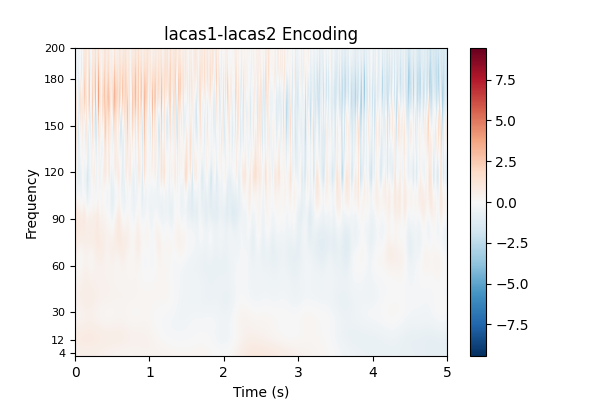

<IPython.core.display.Javascript object>


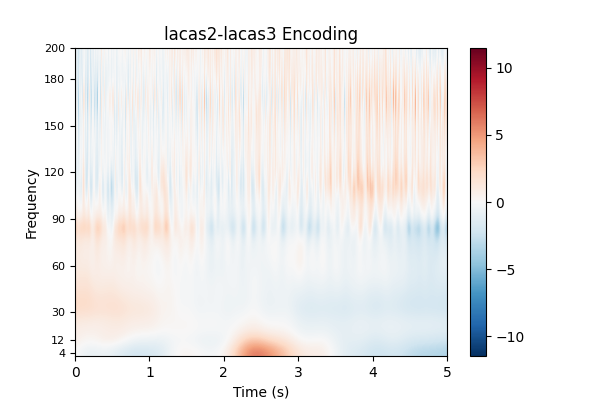

<IPython.core.display.Javascript object>


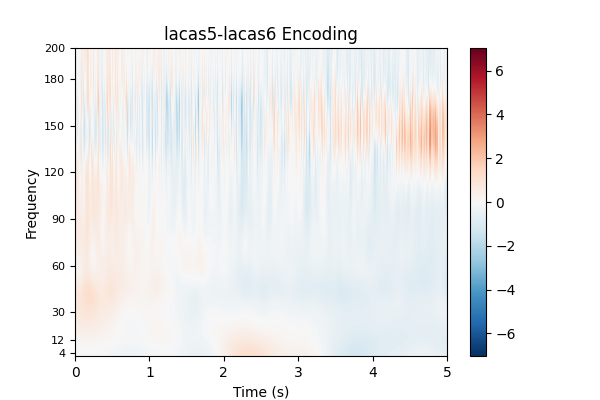

<IPython.core.display.Javascript object>


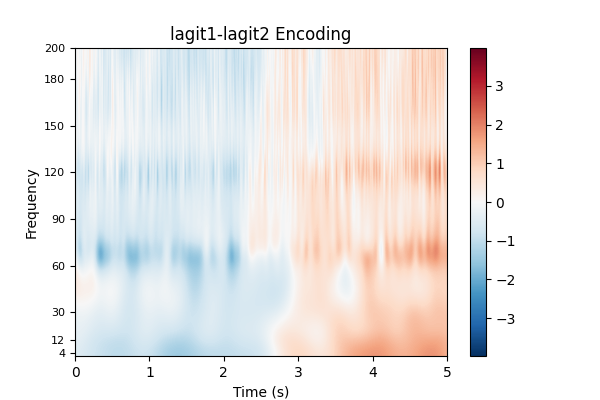

<IPython.core.display.Javascript object>


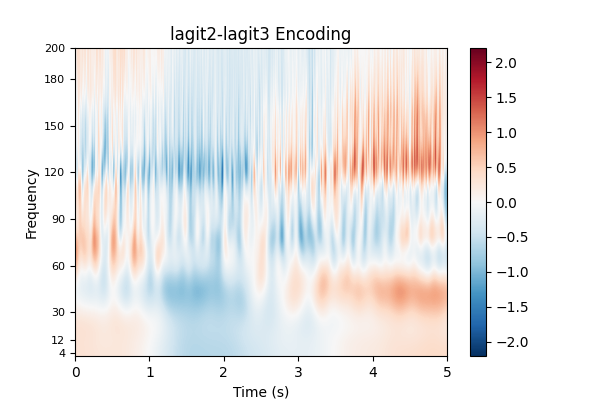

<IPython.core.display.Javascript object>


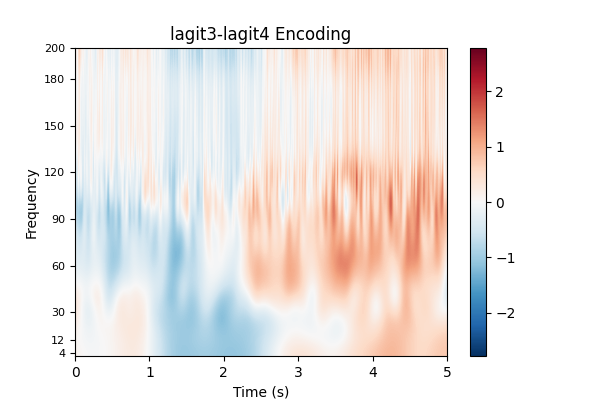

<IPython.core.display.Javascript object>


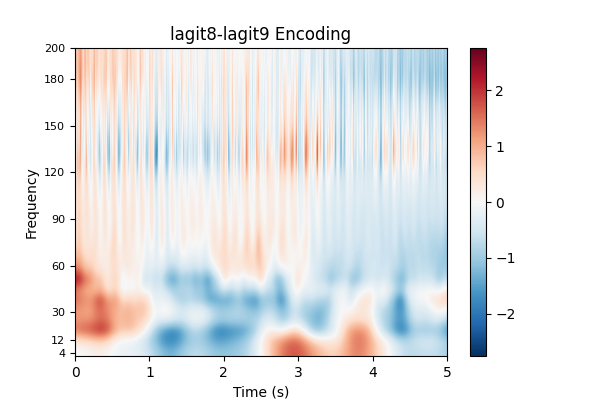

<IPython.core.display.Javascript object>


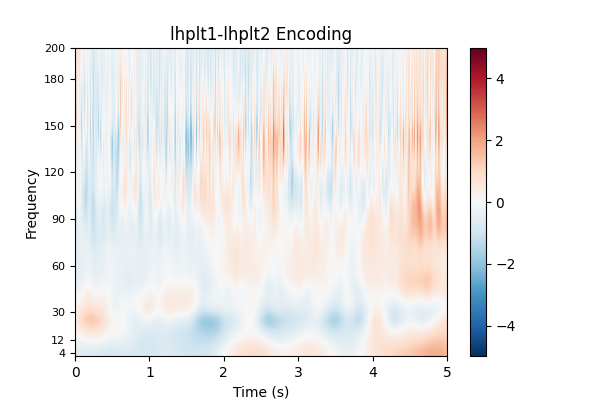

<IPython.core.display.Javascript object>


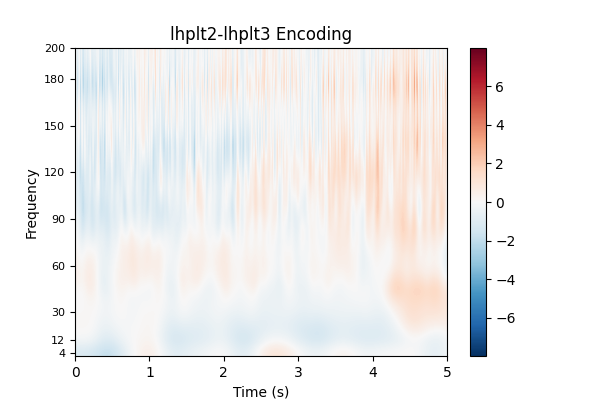

<IPython.core.display.Javascript object>


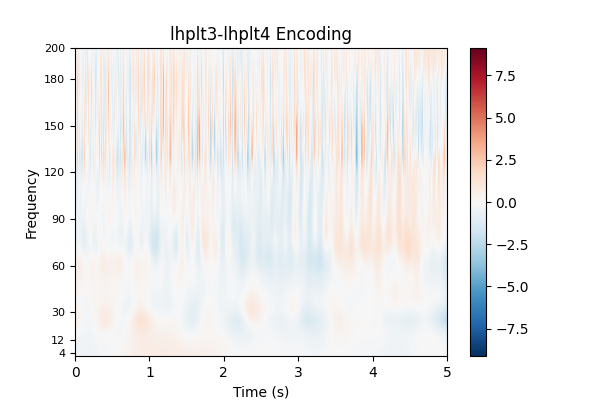

<IPython.core.display.Javascript object>


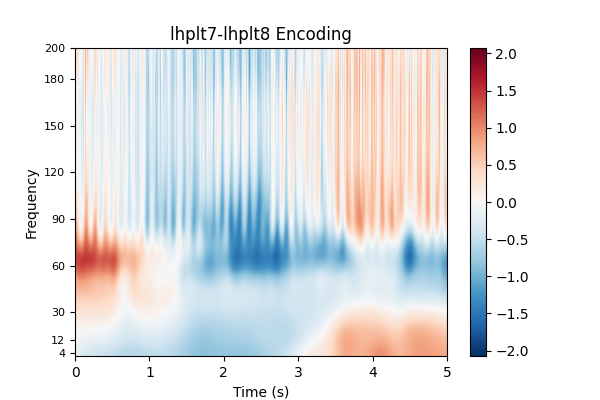

<IPython.core.display.Javascript object>


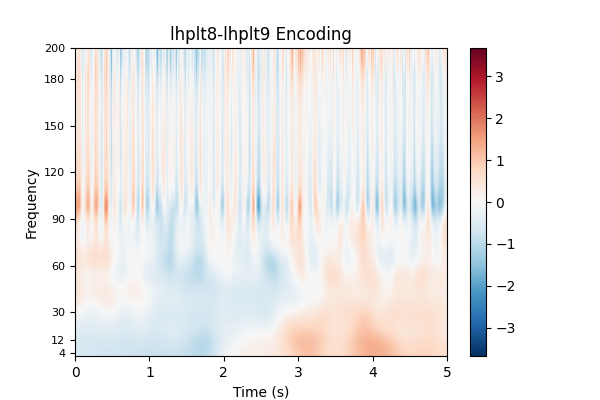

<IPython.core.display.Javascript object>


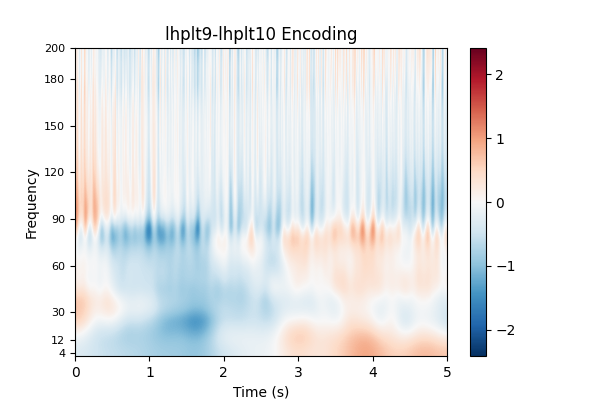

<IPython.core.display.Javascript object>


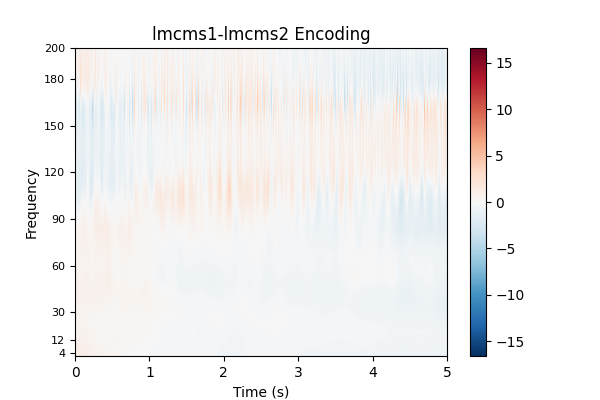

<IPython.core.display.Javascript object>


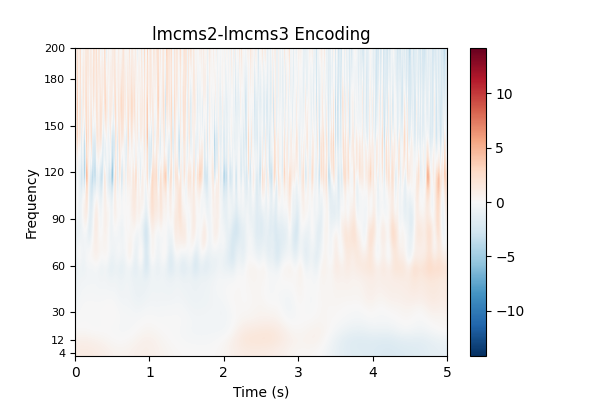

<IPython.core.display.Javascript object>


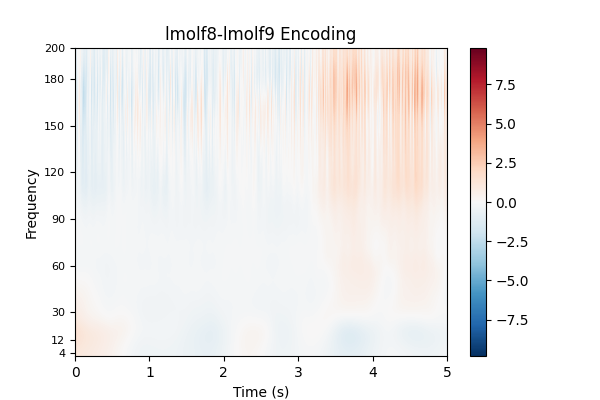

<IPython.core.display.Javascript object>


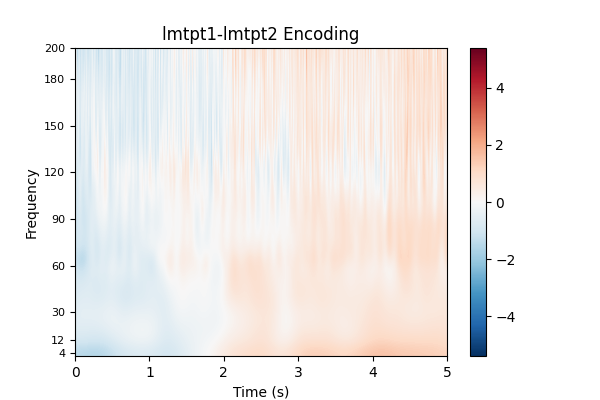

<IPython.core.display.Javascript object>


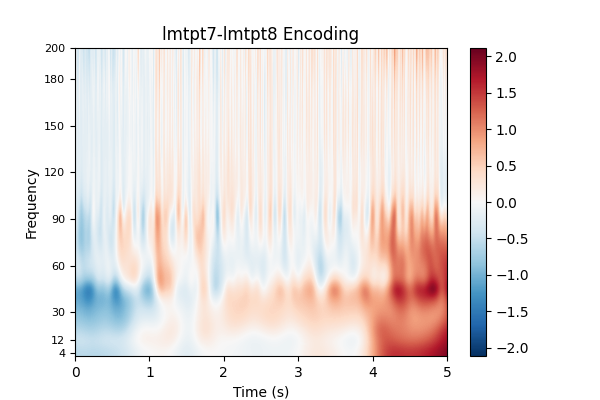

<IPython.core.display.Javascript object>


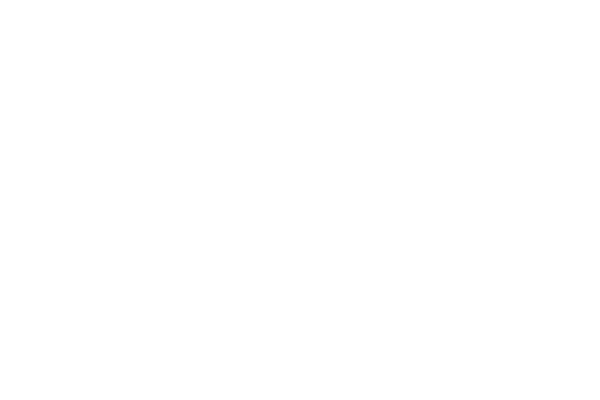

<IPython.core.display.Javascript object>


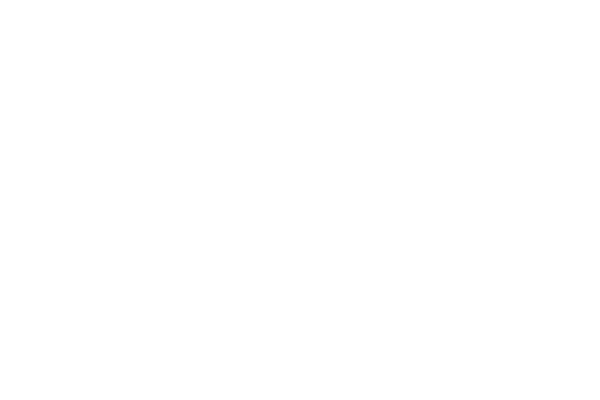

<IPython.core.display.Javascript object>


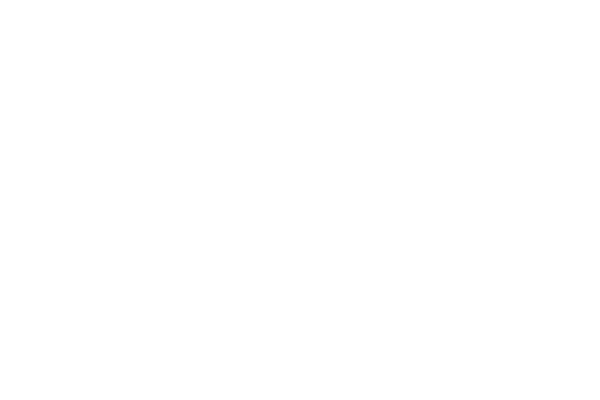

<IPython.core.display.Javascript object>


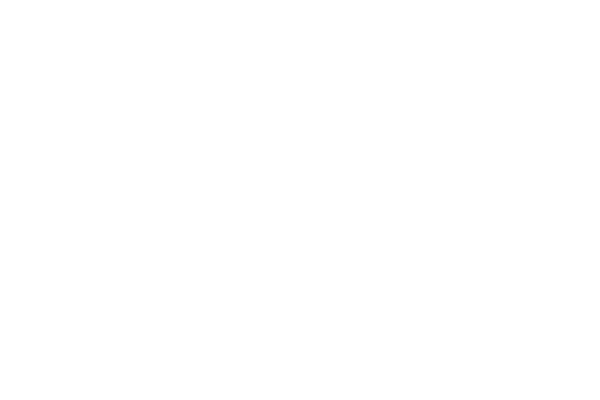

<IPython.core.display.Javascript object>


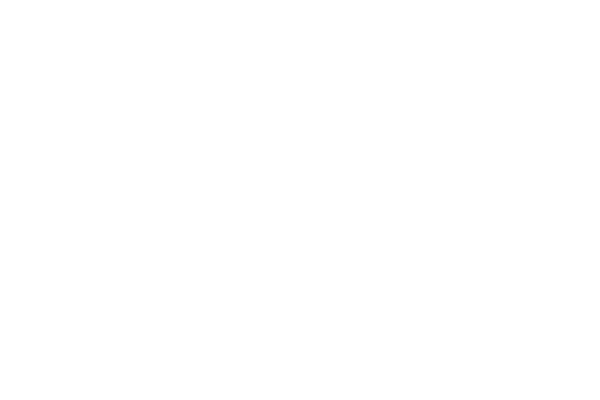

<IPython.core.display.Javascript object>


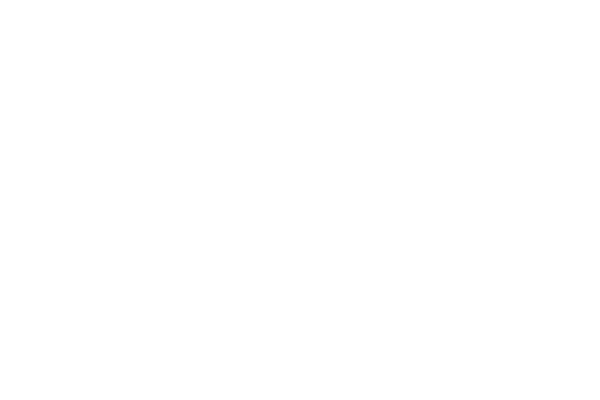

<IPython.core.display.Javascript object>


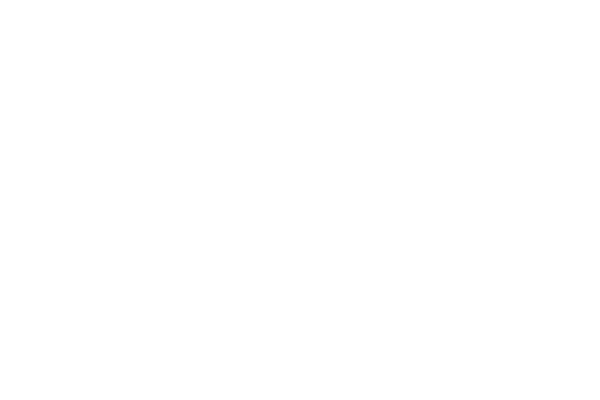

<IPython.core.display.Javascript object>


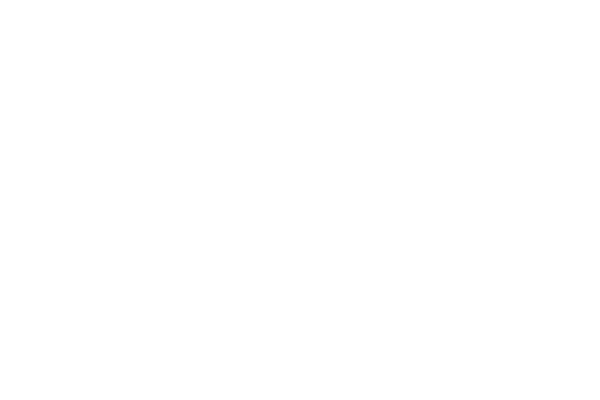

<IPython.core.display.Javascript object>


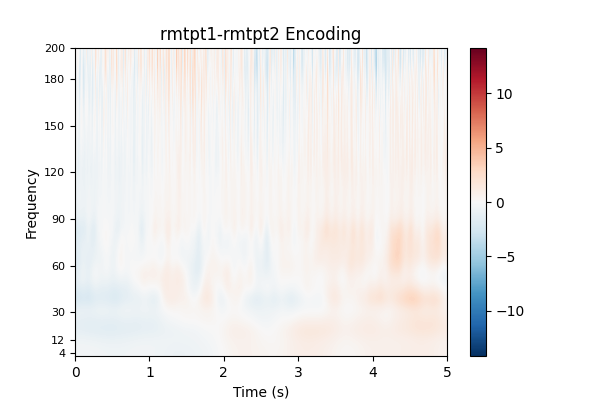

<IPython.core.display.Javascript object>


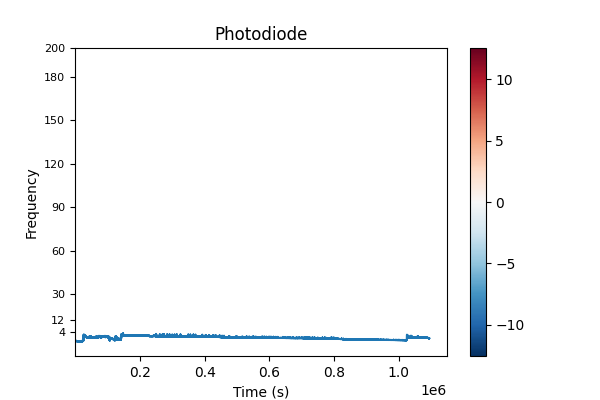

In [109]:
event = 'DecisionOnset'
good_ch = [x for x in power_epochs[event].ch_names if '-' in x]
save_path = tfr_dir

print(offset)


for ch in good_ch:
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    # same for all elec
    times = power_epochs[event].times
    # single ch tfr 
    plot_data = np.nanmean(np.nanmean(power_epochs[event].copy().pick_channels([ch]).data, axis=0), axis=0)

    im = ax.imshow(plot_data,interpolation='Bicubic',
            aspect='auto', origin='lower', cmap='RdBu_r',vmin = -np.nanmax(np.abs(plot_data)), 
                   vmax = np.nanmax(np.abs(plot_data)))
    

    ax.set(xlabel='Time (s)', ylabel='Frequency',title=f'{ch} Encoding',
           yticks=np.arange(0,len(freqs))[::5], 
           yticklabels=freqs[::5].astype(int), 
           xticks = np.arange(plot_data.shape[1])[::250],
              xticklabels= times[::250])
    fig.colorbar(im, ax=ax)
    
    plt.savefig(f'{save_path}/{ch}_{date}_bp_ref.png', format='png', metadata=None,
    bbox_inches=None, pad_inches=0.1,
    facecolor='auto', edgecolor='auto',
    backend=None)
    plt.close()


## check ROIs

In [ ]:
def find_elec_rois(anat_df,reref_ch_names,roi_label_info):
    """
    Get ROI info for bipolar reref elecs

    Parameters
    ----------
    anat_df : pandas.DataFrame
        anatomical reconstruction dataframe for single subj 
    reref_ch_names : list
        List of bipolar-reref channel names 
    roi_label_info : pandas.DataFrame
        Dataframe of custom ROI labels for Saez lab from YBA atlas (consider making a path & loading in fn)

    Returns
    -------
    final_anat_df : pandas.DataFrame
        Updated anat_df with one row for every reref_ch_name that contains ROI, hemisphere, final_loc info, subj_id
    wm_error_df : pandas.DataFrame
        Dataframe containing any reref_ch_names where both anode-cathode are in wm (hopefully empty)
    """ 
    
    # make anat_df labels lowercase 
    anat_df['label'] = anat_df['label'].str.lower()
    # add hemisphere info to anat_df 
#     anat_df['hemi'] = [row['label'].lower()[0] for index, row in anat_df.iterrows()]
#     anat_df = anat_df[(anat_df['hemi']=='r')|(anat_df['hemi']=='l')]
    # make final_loc info lowercase & remove extra spaces
#         # Account for individual differences in labelling: 
#     YBA_label = anat_df.YBA_1.str.lower().str.replace(" ", "")
#     manual_label = anat_df['ManualExamination'].str.lower().str.replace(" ", "")
        # First priority: Use YBA labels if there is no manual label
    anat_df['final_loc'] = [row.ManualExamination.lower() if pd.isna(row.ManualExamination) == False else row.YBA_1.lower() for index, row in elec_locs.iterrows()]

        #     if pd.isna(manual_label).iloc[0]:
#         try:
#             roi = YBA_ROI_labels[YBA_ROI_labels['Long.name']==YBA_label.values[0]].Custom.values[0]
#         except IndexError:
#             # This is probably white matter or out of brain, but not manually labelled as such
#             roi = np.nan
#     else:
#         # Now look at the manual labels: 
#         if YBA_label.str.contains('unknown').iloc[0]:
#             # prioritize thalamus labels! Which are not present in YBA for some reason
#             if (manual_label.str.contains('thalamus').iloc[0]):
#                 roi = 'THAL'
#             else:
#                 try:
#                     roi = YBA_ROI_labels[YBA_ROI_labels['Long.name']==manual_label.values[0]].Custom.values[0]
#                 except IndexError: 
#                     # This is probably white matter or out of brain, and manually labelled as such
#                     roi = np.nan
    
    
#     anat_df['final_loc'] = anat_df['final_loc'].str.lower()
    anat_df['final_loc'] = anat_df['final_loc'].str.strip()
    # extract anode/cathode channel labels from ch names
    anode_elecs = pd.Series(ch_names).str.split('-').str[0]
    cathode_elecs = pd.Series(ch_names).str.split('-').str[1]
    # make separate anode/cathode dfs 
    anode_df = anat_df[anat_df.label.str.lower().isin(anode_elecs)]
    anode_df['reref_ch_name'] = anode_df.label.apply(lambda x: [a for a in ch_names if str(x).lower() in a.split('-')[0]][0])
    cathode_df = anat_df[anat_df.label.str.lower().isin(cathode_elecs)]
    cathode_df['reref_ch_name'] =  cathode_df.label.apply(lambda x: [a for a in ch_names if str(x).lower() in a.split('-')[1]][0])
    # find anodes/cathodes in wm
    wm_labels = ['wm', 'white', 'whitematter', 'white matter']
    wm_anodes = anode_df['reref_ch_name'][anode_df['final_loc'].isin(wm_labels)].tolist()
    wm_cathodes = cathode_df['reref_ch_name'][cathode_df['final_loc'].isin(wm_labels)].tolist()
    # remove wm anodes from anode_df
    grey_anodes = anode_df[(~anode_df.reref_ch_name.str.lower().isin(wm_anodes))]
    # subset grey matter cathodes where anode is wm 
    grey_cathodes = cathode_df[cathode_df.reref_ch_name.str.lower().isin(wm_anodes)]
    # get wm errors (anode-cathode both wm)
    wm_error_df = grey_cathodes[grey_cathodes['final_loc'].str.lower().isin(wm_labels)]
    # remove error elecs from df 
    grey_cathodes = grey_cathodes[~grey_cathodes['final_loc'].str.lower().isin(wm_labels)]
    # save all elecs in df 
    final_anat_df = grey_anodes.append(grey_cathodes, ignore_index=True)
    # add roi of final elec label to anat_df 
    final_anat_df['roi'] = [roi_label_info['Custom'][np.where(row['final_loc'] == roi_label_info['Long.name'])[0]].item() 
                  if pd.Series(row['final_loc']).isin(roi_label_info['Long.name'])[0] else float("nan")
                  for index, row in final_anat_df.iterrows()]
    # add subject_id to concat all dfs together 
    final_anat_df['subj_id'] = subj_id
    wm_error_df['subj_id'] = subj_id
    
    return final_anat_df, wm_error_df



In [ ]:
anode_elecs = pd.Series(mne_data_bp_reref.ch_names).str.split('-').str[0]
anode_elecs

In [ ]:
#### Anatomical localization 

# ROI labels for YBA regions
roi_label_info = pd.read_excel('/sc/arion/projects/guLab/Alie/SWB/ephys_analysis/LFPAnalysis/LFPAnalysis/YBA_ROI_labelled.xlsx', 
                               usecols=['Hemisphere','Custom','Long.name'])

roi_label_info = roi_label_info.apply(lambda x: x.str.lower())
roi_label_info = roi_label_info.apply(lambda x: x.str.strip())

In [ ]:
for reref_label in mne_data_bp_reref.ch_names:
    anode = reref_label.split('-')[0]
    cathode = reref_label.split('-')[1]
    anode_roi = final_anat_df[final_anat_df.label == anode].roi
    cathode_roi = final_anat_df[final_anat_df.label == cathode].roi
    print(anode_roi,cathode_roi)
    
    